### Lets Do Semantic Image Segmenatation on Indian Traffic Dataset

### Import Section


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import datetime
import time
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from google.colab.patches import cv2_imshow
import glob
import pathlib
import json
from tqdm import tqdm
tqdm.pandas()
! pip3 install -U segmentation-models
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
from segmentation_models import Unet
tf.keras.backend.set_image_data_format('channels_last')
from sklearn.model_selection import train_test_split
import imgaug.augmenters as iaa
from segmentation_models.metrics import iou_score
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow.keras.backend as K
from tensorflow.keras.utils import plot_model

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 7.1 MB/s eta 0:00:00
env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


<pre>
1. You can download the data from this link, and extract it

2. All your data will be in the folder "data" 

3. Inside the data you will be having two folders

|--- data
|-----| ---- images
|-----| ------|----- Scene 1
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
|-----| ---- masks
|-----| ------|----- Scene 1
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
</pre>

In [2]:
!pip install --upgrade --no-cache-dir gdown
!gdown 1iQ93IWVdR6dZ6W7RahbLq166u-6ADelJ

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
Downloading...
From: https://drive.google.com/uc?id=1iQ93IWVdR6dZ6W7RahbLq166u-6ADelJ
To: /content/data.zip
100% 2.34G/2.34G [00:23<00:00, 101MB/s] 


In [3]:
!mkdir dataset
!unzip /content/data.zip -d dataset

Streaming output truncated to the last 5000 lines.
  inflating: dataset/data/images/377/frame28480_leftImg8bit.jpg  
  inflating: dataset/data/images/377/frame28699_leftImg8bit.jpg  
  inflating: dataset/data/images/377/frame28808_leftImg8bit.jpg  
  inflating: dataset/data/images/377/frame29080_leftImg8bit.jpg  
  inflating: dataset/data/images/377/frame29271_leftImg8bit.jpg  
  inflating: dataset/data/images/377/frame29435_leftImg8bit.jpg  
  inflating: dataset/data/images/377/frame29653_leftImg8bit.jpg  
  inflating: dataset/data/images/377/frame29817_leftImg8bit.jpg  
  inflating: dataset/data/images/377/frame30062_leftImg8bit.jpg  
  inflating: dataset/data/images/377/frame30199_leftImg8bit.jpg  
  inflating: dataset/data/images/377/frame3039_leftImg8bit.jpg  
  inflating: dataset/data/images/377/frame30417_leftImg8bit.jpg  
  inflating: dataset/data/images/377/frame30499_leftImg8bit.jpg  
  inflating: dataset/data/images/377/frame30608_leftImg8bit.jpg  
  inflating: dataset/data/

# Task 1: Preprocessing

## 1. Get all the file name and corresponding json files

In [4]:
def return_file_names_df(root_dir):
    # write the code that will create a dataframe with two columns ['images', 'json']
    # the column 'image' will have path to images
    # the column 'json' will have path to json files
    unique_ids = os.listdir(root_dir)
    image_path = '/content/dataset/data/images/'
    json_path = '/content/dataset/data/mask/'
    images = []
    json = []
    for i in unique_ids:        
        images.extend([image_path+str(i)+'/'+img for img in sorted(set(os.listdir(image_path+str(i))))])# using sorted set to maintain elements order while converting set to list.(Finxter)
        json.extend([json_path+str(i)+'/'+json for json in sorted(set(os.listdir(json_path+str(i))))])
    data_df = pd.DataFrame(list(zip(images,json)),columns=['images','json'])
    return data_df

In [5]:
root_dir = '/content/dataset/data/images'
data_df = return_file_names_df(root_dir)
data_df.head()

,images,json
0,/content/dataset/data/images/380/frame0065_lef...,/content/dataset/data/mask/380/frame0065_gtFin...
1,/content/dataset/data/images/380/frame0145_lef...,/content/dataset/data/mask/380/frame0145_gtFin...
2,/content/dataset/data/images/380/frame10199_le...,/content/dataset/data/mask/380/frame10199_gtFi...
3,/content/dataset/data/images/380/frame10265_le...,/content/dataset/data/mask/380/frame10265_gtFi...
4,/content/dataset/data/images/380/frame11879_le...,/content/dataset/data/mask/380/frame11879_gtFi...


> If you observe the dataframe, we can consider each row as single data point, where first feature is image and the second feature is corresponding json file

In [6]:
data_df.shape

(4008, 2)

## 2. Structure of sample Json file

<center><img src='https://i.imgur.com/EfR5KmI_d.webp?maxwidth=760&fidelity=grand' width="300" height="600"></center>

* Each File will have 3 attributes
    * imgHeight: which tells the height of the image
    * imgWidth: which tells the width of the image
    * objects: it is a list of objects, each object will have multiple attributes,
        * label: the type of the object
        * polygon: a list of two element lists, representing the coordinates of the polygon

#### Compute the unique labels

Let's see how many unique objects are there in the json file.
to see how to get the object from the json file please check <a href='https://www.geeksforgeeks.org/read-json-file-using-python/'>this blog </a>

In [7]:
def return_unique_labels(data_df):
    # for each file in the column json
    #       read and store all the objects present in that file
    # compute the unique objects and retrun them
    # if open any json file using any editor you will get better sense of it
    labels = []
    for i in data_df['json'].values:
      f= open(i)
      data = json.load(f)
      for j in data['objects']: 
          labels.append(j['label'])       
    df_label = pd.DataFrame(labels,columns=['label']) 
    unique_labels = dict(df_label['label'].value_counts())
    return unique_labels

In [8]:
unique_labels = return_unique_labels(data_df)

In [9]:
unique_labels

{'vegetation': 117858,
 'obs-str-bar-fallback': 91321,
 'pole': 51485,
 'billboard': 21212,
 'motorcycle': 18515,
 'building': 16884,
 'rider': 16617,
 'car': 13641,
 'person': 13086,
 'vehicle fallback': 9581,
 'drivable fallback': 7762,
 'non-drivable fallback': 7267,
 'autorickshaw': 6288,
 'truck': 6098,
 'traffic sign': 5769,
 'curb': 5681,
 'wall': 5562,
 'sky': 4115,
 'road': 4114,
 'fence': 1917,
 'animal': 1913,
 'fallback background': 1651,
 'bus': 1604,
 'guard rail': 1569,
 'sidewalk': 886,
 'bridge': 476,
 'bicycle': 417,
 'polegroup': 407,
 'traffic light': 356,
 'out of roi': 166,
 'caravan': 58,
 'parking': 17,
 'trailer': 6,
 'tunnel': 5,
 'train': 4,
 'rail track': 4,
 'rectification border': 3,
 'ego vehicle': 2,
 'unlabeled': 2,
 'ground': 2}

<img src='https://i.imgur.com/L4QH6Tp.png'>

In [10]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}

<pre>
* here we have given a number for each of object types, if you see we are having 21 different set of objects
* Note that we have multiplies each object's number with 10, that is just to make different objects look differently in the segmentation map
* Before you pass it to the models, you might need to devide the image array /10.
</pre>

## 3. Extracting the polygons from the json files

In [12]:
def get_poly(file):
    # this function will take a file name as argument
    
    # it will process all the objects in that file and returns
    
    # label: a list of labels for all the objects label[i] will have the corresponding vertices in vertexlist[i]
    # len(label) == number of objects in the image
    
    # vertexlist: it should be list of list of vertices in tuple formate 
    # ex: [[(x11,y11), (x12,y12), (x13,y13) .. (x1n,y1n)]
    #     [(x21,y21), (x22,y12), (x23,y23) .. (x2n,y2n)]
    #      .....
    #     [(xm1,ym1), (xm2,ym2), (xm3,ym3) .. (xmn,ymn)]]
    # len(vertexlist) == number of objects in the image
    
    # * note that label[i] and vertextlist[i] are corresponds to the same object, one represents the type of the object
    # the other represents the location
    
    # width of the image
    # height of the image
    label = []
    vertexlist=[]
    f= open(file)
    data = json.load(f)
    w = data['imgWidth']
    h = data['imgHeight']
    # print(data)
    for j in data['objects']: 
        label.append(j['label']) 
        vertexlist.append([tuple(i) for i in j['polygon']])
    return w, h, label, vertexlist

In [13]:
def grader_3(file):
    w, h, labels, vertexlist = get_poly(file)
    print(len((set(labels)))==18 and len(vertexlist)==227 and w==1920 and h==1080 \
          and isinstance(vertexlist,list) and isinstance(vertexlist[0],list) and isinstance(vertexlist[0][0],tuple) )

grader_3('/content/dataset/data/mask/201/frame0029_gtFine_polygons.json')

True


## 4. Creating Image segmentations by drawing set of polygons

### Example

(28, 28, 3)
[[0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 

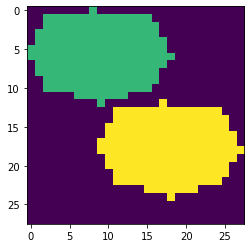

In [14]:
import math 
from PIL import Image, ImageDraw 
from PIL import ImagePath  
side=8
x1 = [ ((math.cos(th) + 1) *9, (math.sin(th) + 1) * 6) for th in [i * (2 * math.pi) / side for i in range(side)] ]
x2 = [ ((math.cos(th) + 2) *9, (math.sin(th) + 3) *6) for th in [i * (2 * math.pi) / side for i in range(side)] ]

img = Image.new("RGB", (28,28))
img1 = ImageDraw.Draw(img)
# please play with the fill value
# writing the first polygon
img1.polygon(x1, fill =20)
# writing the second polygon
img1.polygon(x2, fill =30)

img=np.array(img)
# note that the filling of the values happens at the channel 1, so we are considering only the first channel here
plt.imshow(img[:,:,0])
print(img.shape)
print(img[:,:,0]//10)
im = Image.fromarray(img[:,:,0])
im.save("test_image.png")

In [15]:
def compute_masks(data_df):
    # after you have computed the vertexlist plot that polygone in image like this
    
    # img = Image.new("RGB", (w, h))
    # img1 = ImageDraw.Draw(img)
    # img1.polygon(vertexlist[i], fill = label_clr[label[i]])
    
    # after drawing all the polygons that we collected from json file, 
    # you need to store that image in the folder like this "data/output/scene/framenumber_gtFine_polygons.png"
    
    # after saving the image into disk, store the path in a list
    # after storing all the paths, add a column to the data_df['mask'] ex: data_df['mask']= mask_paths
    mask = []
    for i in tqdm(data_df['json']):
        w,h,lable, vertex = get_poly(i)
        img = Image.new("RGB",size = (w,h))
        img1 = ImageDraw.Draw(img)
        for l,v in zip(lable,vertex):
            try:
                img1.polygon(v, fill = label_clr[l])
            except TypeError as e:
                pass
                #this error arises due to empty vertex\
                # in polygon, un comment below print to see how many vertex is empty in this i'th json file
                # print(i,v) 
        #changing file type from json to png and saving it to mask column
        img=np.array(img)
        # print(img[:,:,0]//10)
        im = Image.fromarray(img[:,:,0])
        p = i.replace('mask','output')
        png_file = p.replace('json','png')
        try:
            os.makedirs(png_file[:32])
        except FileExistsError:
            pass
        im.save(png_file)
        mask.append(png_file)
    data_df['mask'] = mask
    return data_df

In [16]:
data_df = compute_masks(data_df)
data_df.head()

100%|██████████| 4008/4008 [04:20<00:00, 15.38it/s]


,images,json,mask
0,/content/dataset/data/images/380/frame0065_lef...,/content/dataset/data/mask/380/frame0065_gtFin...,/content/dataset/data/output/380/frame0065_gtF...
1,/content/dataset/data/images/380/frame0145_lef...,/content/dataset/data/mask/380/frame0145_gtFin...,/content/dataset/data/output/380/frame0145_gtF...
2,/content/dataset/data/images/380/frame10199_le...,/content/dataset/data/mask/380/frame10199_gtFi...,/content/dataset/data/output/380/frame10199_gt...
3,/content/dataset/data/images/380/frame10265_le...,/content/dataset/data/mask/380/frame10265_gtFi...,/content/dataset/data/output/380/frame10265_gt...
4,/content/dataset/data/images/380/frame11879_le...,/content/dataset/data/mask/380/frame11879_gtFi...,/content/dataset/data/output/380/frame11879_gt...


In [17]:
#Saving the final dataframe to a csv file
data_df.to_csv('preprocessed_data.csv', index=False)

In [18]:
data_df = pd.read_csv('/content/preprocessed_data.csv')
data_df.head()

,images,json,mask
0,/content/dataset/data/images/380/frame0065_lef...,/content/dataset/data/mask/380/frame0065_gtFin...,/content/dataset/data/output/380/frame0065_gtF...
1,/content/dataset/data/images/380/frame0145_lef...,/content/dataset/data/mask/380/frame0145_gtFin...,/content/dataset/data/output/380/frame0145_gtF...
2,/content/dataset/data/images/380/frame10199_le...,/content/dataset/data/mask/380/frame10199_gtFi...,/content/dataset/data/output/380/frame10199_gt...
3,/content/dataset/data/images/380/frame10265_le...,/content/dataset/data/mask/380/frame10265_gtFi...,/content/dataset/data/output/380/frame10265_gt...
4,/content/dataset/data/images/380/frame11879_le...,/content/dataset/data/mask/380/frame11879_gtFi...,/content/dataset/data/output/380/frame11879_gt...


# Task 2: Applying Unet to segment the images

<pre>
* please check the paper: https://arxiv.org/abs/1505.04597

* <img src='https://i.imgur.com/rD4yP7J.jpg' width="500">

* As a part of this assignment we won't writingt this whole architecture, rather we will be doing transfer learning

* please check the library <a hreaf='https://github.com/qubvel/segmentation_models'>https://github.com/qubvel/segmentation_models</a>

* You can install it like this "pip install -U segmentation-models==0.2.1", even in google colab you can install the    same with "!pip install -U segmentation-models==0.2.1" 

* Check the reference notebook in which we have solved one end to end case study of image forgery detection using same  unet

* The number of channels in the output will depend on the number of classes in your data, since we know that we are having 21 classes, the number of channels in the output will also be 21

* <strong>This is where we want you to explore, how do you featurize your created segmentation map note that the original map will be of (w, h, 1) and the output will be (w, h, 21) how will you calculate the loss</strong>, you can check the examples in segmentation github

* please use the loss function that is used in the refence notebooks

</pre>

### Task 2.1: Dice loss

* Explain the Dice loss

> Dice loss originates from Sørensen–Dice coefficient, which is a statistic developed in 1940s to gauge the similarity between two samples [Wikipedia]. It was brought to computer vision community by Milletari et al. in 2016 for 3D medical image segmentation.
<center><img src = 'https://miro.medium.com/max/514/1*EF3VCtk-VbTIKhriaQF0YQ.webp'></center>

> Above equation of Dice coefficient, in which pi and gi represent pairs of corresponding pixel values of prediction and ground truth, respectively. In boundary detection scenario, the values of pi and gi are either 0 or 1, representing whether the pixel is boundary (value of 1) or not (value of 0). Therefore, the denominator is the sum of total boundary pixels of both prediction and ground truth, and the numerator is the sum of correctly predicted boundary pixels because the sum increments only when pi and gi match (both of value 1).

<center><img src = "https://miro.medium.com/max/1400/1*oK8npb1wtF-GKeHi7yIBoQ.webp" width = 500></center>
<pre>
* 1. Write the formualtion
    D = 2 * sum(Xi * Yi) / sum(squre(Xi) * sum(sqare(Yi))
    dice_loss = 1 - D
* 2. Range of the loss function = 0 to 1
* 3. Interpretation of loss function
* 4. Write your understanding of the loss function, how does it helps in segmentation
</pre>

- We prefer Dice Loss instead of Cross Entropy because most of the semantic segmentation comes from an unbalanced dataset. 
- Suppose you have an image of a cat and you want to segment your image as cat(foreground) vs not-cat(background).
- In most of these image cases you will likely see most of the pixel in an image that is not-cat. And on an average you may find that 70-90% of the pixel in the image corresponds to background and only 10-30% on the foreground.
- So, if one use CE loss the algorithm may predict most of the pixel as background even when they are not and still get low errors.
- But in case of Dice Loss ( function of Intersection and Union over foreground pixel ) if the model predicts all the pixel as background the intersection would be 0 this would give rise to error=1 ( maximum error as Dice loss is between 0 and 1).
- What if I predict all the pixel as foreground ???
- In such case, the Union will become quite large and this will increase the loss to 1.
- Hence, Dice loss gives low error as it focuses on maximising the intersection area over foreground while minimising the Union over foreground.




### Task 2.2: Training Unet


<pre>
* Split the data into 80:20.
* Train the UNET on the given dataset and plot the train and validation loss.
* As shown in the reference notebook plot 20 images from the test data along with its segmentation map, predicted map.
</pre>

In [19]:
X_train, X_test = train_test_split(data_df, test_size=0.10)

In [20]:
X_train.head()

,images,json,mask
1229,/content/dataset/data/images/404/frame1700_lef...,/content/dataset/data/mask/404/frame1700_gtFin...,/content/dataset/data/output/404/frame1700_gtF...
1883,/content/dataset/data/images/421/0015552_leftI...,/content/dataset/data/mask/421/0015552_gtFine_...,/content/dataset/data/output/421/0015552_gtFin...
1469,/content/dataset/data/images/403/0012223_leftI...,/content/dataset/data/mask/403/0012223_gtFine_...,/content/dataset/data/output/403/0012223_gtFin...
1189,/content/dataset/data/images/347/frame1811_lef...,/content/dataset/data/mask/347/frame1811_gtFin...,/content/dataset/data/output/347/frame1811_gtF...
1995,/content/dataset/data/images/320/frame9579_lef...,/content/dataset/data/mask/320/frame9579_gtFin...,/content/dataset/data/output/320/frame9579_gtF...


In [21]:
# For the assignment choose any 4 augumentation techniques
# check the imgaug documentations for more augmentations
aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
aug6 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))

In [22]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if i==1:
            plt.imshow(image, cmap='gray', vmax=1, vmin=0)
        else:
            plt.imshow(image)
    plt.show()

In [23]:
def normalize_image(mask):
  mask = mask/255
  return mask

In [24]:
class Dataset:
    # we will be modifying this CLASSES according to your data/problems
    CLASSES = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
    # the parameters needs to changed based on your requirements
    # here we are collecting the file_names because in our dataset, both our images and maks will have same file name
    # ex: fil_name.jpg   file_name.mask.jpg
    def __init__(self, file_names, classes = None):
        self.w = 512
        self.h = 512
        self.ids = file_names
        # the paths of images
        self.images_fps   = [image_id for image_id in self.ids['images']]
        # the paths of segmentation images
        self.masks_fps    = [image_id for image_id in self.ids['mask']]
        # giving labels for each class
        self.class_values = [self.CLASSES.index(cls) for cls in classes]
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED) 
        image = cv2.resize(image,(self.w,self.h),interpolation=cv2.INTER_AREA)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = normalize_image(image)
        mask  = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)
        mask = cv2.resize(mask,(self.w,self.h),interpolation=cv2.INTER_AREA)
        mask = mask/10
        image_masks = [(mask == v) for v in self.class_values] # this line use unique color(that we speciified before as lable_clr) to seperate each class
        image_mask = np.stack(image_masks, axis=-1).astype('float')
   
        a = np.random.uniform()
        if a<0.2:
            image = aug2.augment_image(image)
            image_mask = aug2.augment_image(image_mask)
        elif a<0.4:
            image = aug3.augment_image(image)
            image_mask = aug3.augment_image(image_mask)
        elif a<0.6:
            image = aug4.augment_image(image)
            image_mask = aug4.augment_image(image_mask)
        elif a<0.8:
            image = aug5.augment_image(image)
            image_mask = image_mask
        else:
            image = aug6.augment_image(image)
            image_mask = aug6.augment_image(image_mask)
            
        return image, image_mask
        
    def __len__(self):
        return len(self.images_fps)
    

In [25]:
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [26]:
CLASSES = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
BATCH_SIZE = 8
IMAGE_SHAPE = (512, 512, 3)
n_classes = len(CLASSES)   


In [27]:
train_dataset = Dataset(X_train, classes=CLASSES)
val_dataset  = Dataset(X_test, classes=CLASSES)

train_dataloader = Dataloder(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_dataloader = Dataloder(val_dataset, batch_size = BATCH_SIZE, shuffle = True)

print(train_dataloader[0][0].shape)
assert train_dataloader[0][0].shape == (BATCH_SIZE, 512, 512, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 512, 512, n_classes)

(8, 512, 512, 3)


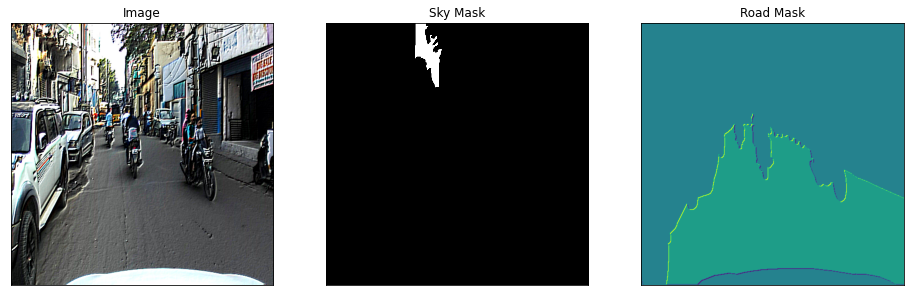

In [28]:
img, mas = train_dataset[51]
visualize(image = img, sky_mask = mas[:, :, 16], road_mask = mas[:, :, 1])

In [29]:
tf.keras.backend.clear_session()
unet_model = Unet('densenet121', input_shape = IMAGE_SHAPE, classes = n_classes, activation = 'softmax', encoder_freeze = True,encoder_weights = 'imagenet')

29084464/29084464 [==============================] - 2s 0us/step


In [ ]:
unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 518, 518, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 256, 256, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [ ]:
plot_model(unet_model, to_file='unet_model.png', show_shapes=True, show_layer_names=True)

Output hidden; open in https://colab.research.google.com to view.

In [30]:
optim = tf.keras.optimizers.Adam(0.001)
focal_loss = sm.losses.cce_dice_loss



In [31]:
# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss 
# or total_loss = sm.losses.categorical_focal_dice_loss 

unet_model.compile(optim, focal_loss, metrics=[iou_score])

In [32]:
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, \
                                       mode='max', monitor='val_iou_score'),
    ReduceLROnPlateau(monitor='val_iou_score', min_lr=0.000001,patience=3),
    
]

In [33]:
train_steps = X_train.shape[0]//BATCH_SIZE
valid_steps = X_test.shape[0]//BATCH_SIZE
len(train_dataloader), train_steps

(450, 450)

In [ ]:
unet_model_history = unet_model.fit(train_dataloader, steps_per_epoch = train_steps, epochs = 10,\
                                validation_data = val_dataloader, validation_steps = valid_steps,
                                callbacks = callbacks)

Epoch 1/10
450/450 [==============================] - 751s 2s/step - loss: 0.7135 - iou_score: 0.2617 - val_loss: 0.8528 - val_iou_score: 0.1970 - lr: 0.0010
Epoch 2/10
450/450 [==============================] - 708s 2s/step - loss: 0.5876 - iou_score: 0.3651 - val_loss: 0.6282 - val_iou_score: 0.3420 - lr: 0.0010
Epoch 3/10
450/450 [==============================] - 707s 2s/step - loss: 0.5496 - iou_score: 0.3989 - val_loss: 0.5687 - val_iou_score: 0.3844 - lr: 0.0010
Epoch 4/10
450/450 [==============================] - 704s 2s/step - loss: 0.5284 - iou_score: 0.4188 - val_loss: 0.5340 - val_iou_score: 0.4113 - lr: 0.0010
Epoch 5/10
450/450 [==============================] - 711s 2s/step - loss: 0.4943 - iou_score: 0.4502 - val_loss: 0.4945 - val_iou_score: 0.4508 - lr: 1.0000e-04
Epoch 6/10
450/450 [==============================] - 717s 2s/step - loss: 0.4843 - iou_score: 0.4606 - val_loss: 0.4985 - val_iou_score: 0.4456 - lr: 1.0000e-04
Epoch 7/10
450/450 [========================

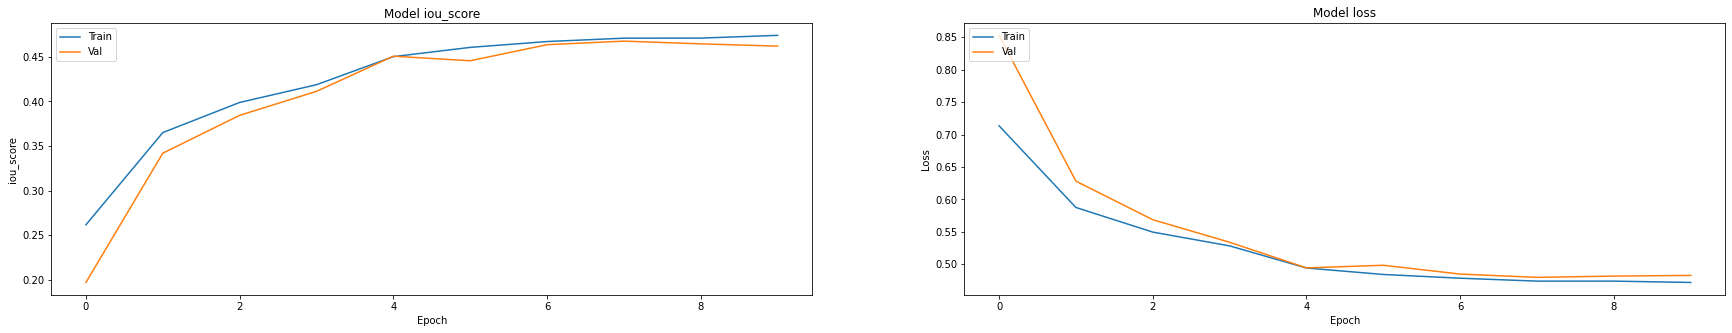

In [ ]:


# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(unet_model_history.history['iou_score'])
plt.plot(unet_model_history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(unet_model_history.history['loss'])
plt.plot(unet_model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
     


In [34]:
!gdown 11IjppPuskvKrXX5lPFtg0ke-rDfbGkxB

Downloading...
From: https://drive.google.com/uc?id=11IjppPuskvKrXX5lPFtg0ke-rDfbGkxB
To: /content/best_model.h5
100% 49.6M/49.6M [00:00<00:00, 182MB/s]


In [35]:
unet_model.load_weights('/content/best_model.h5')

In [36]:
images_ = X_test['images'].values
masks_ = X_test['mask'].values
lst = np.arange(len(images_))

1/1 [==============================] - 15s 15s/step


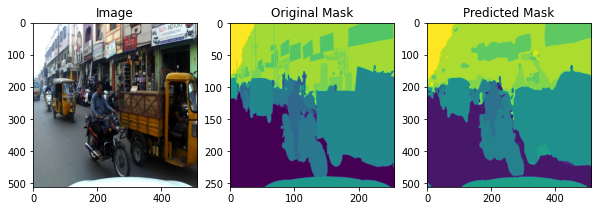

1/1 [==============================] - 0s 73ms/step


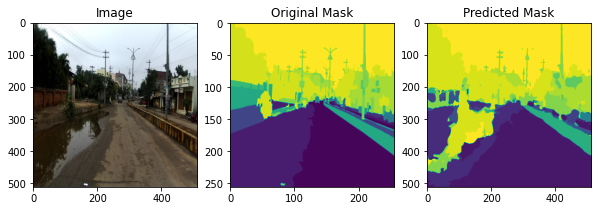

1/1 [==============================] - 0s 48ms/step


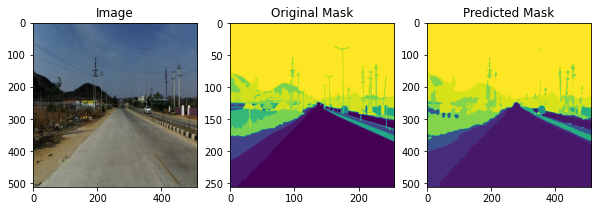

1/1 [==============================] - 0s 54ms/step


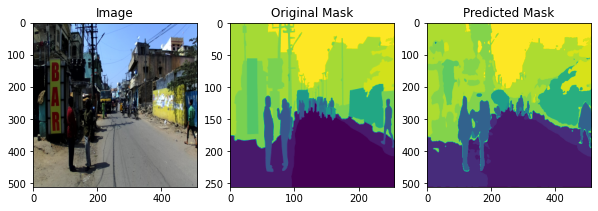

1/1 [==============================] - 0s 32ms/step


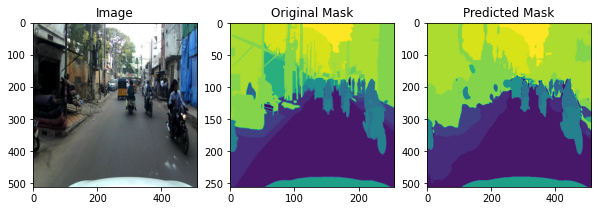

1/1 [==============================] - 0s 35ms/step


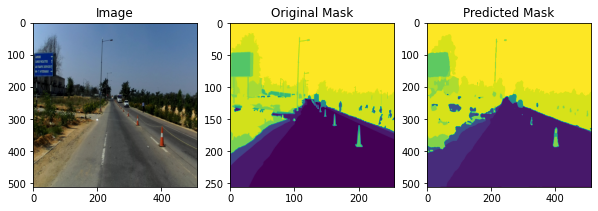

1/1 [==============================] - 0s 31ms/step


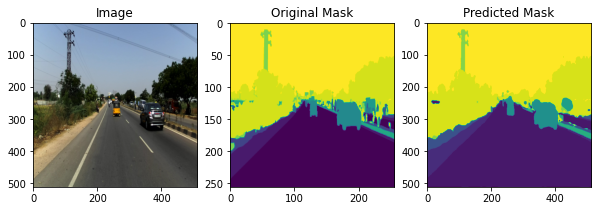

1/1 [==============================] - 0s 33ms/step


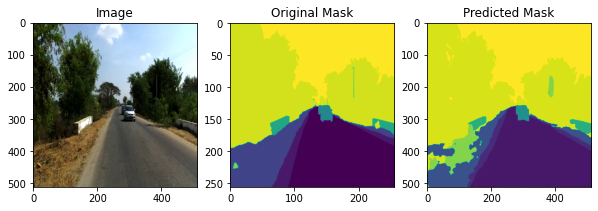

1/1 [==============================] - 0s 32ms/step


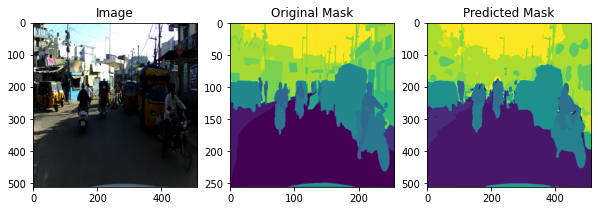

1/1 [==============================] - 0s 34ms/step


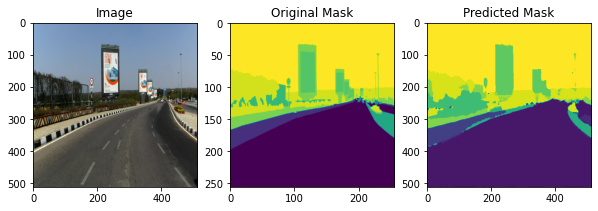

1/1 [==============================] - 0s 31ms/step


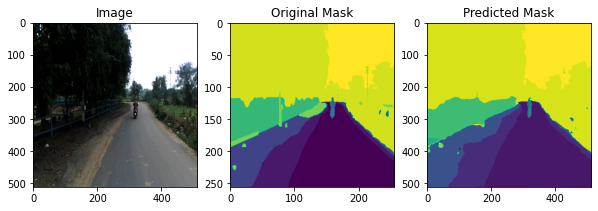

1/1 [==============================] - 0s 33ms/step


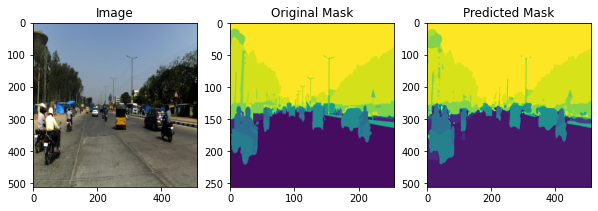

1/1 [==============================] - 0s 35ms/step


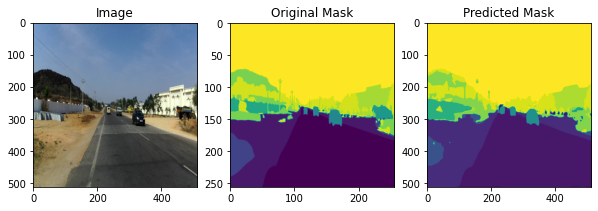

1/1 [==============================] - 0s 32ms/step


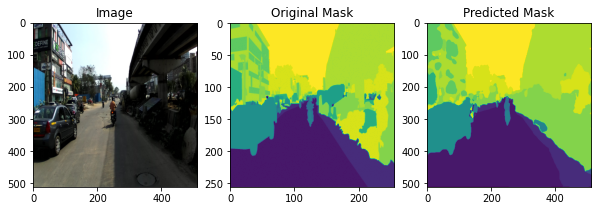

1/1 [==============================] - 0s 31ms/step


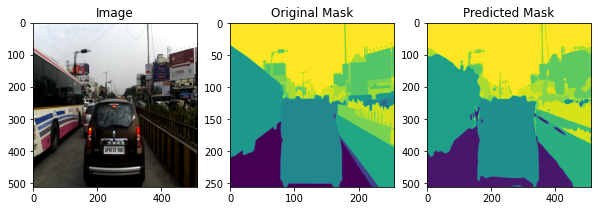

In [37]:
# Visualizing the predicted mask for val data.
import random
ids = np.random.choice(lst, size = 15, replace = False)
for i in ids:
  image = cv2.imread(images_[i], cv2.IMREAD_UNCHANGED)
  image = cv2.resize(image, (512, 512),  interpolation = cv2.INTER_AREA)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = image/255
  image = np.expand_dims(image, axis=0)

  mask  = cv2.imread(masks_[i], cv2.IMREAD_UNCHANGED)
  mask = cv2.resize(mask, (256, 256),  interpolation = cv2.INTER_AREA)
  mask = mask /10
  pred = unet_model.predict(image,verbose=1)
  pred = tf.argmax(pred, axis=-1)

  fig = plt.figure(figsize=(10,6))
  #plt.figure(figsize=(10,6))
  ax1 = fig.add_subplot(131)
  ax1.imshow(image[0,:,:])
  ax2=fig.add_subplot(132)
  ax2.imshow(mask)
  ax3=fig.add_subplot(133)
  ax3.imshow(pred[0,:,:])
  ax1.title.set_text('Image')
  ax2.title.set_text('Original Mask')
  ax3.title.set_text('Predicted Mask')
  plt.show()
     


## Lets Apply our model to the traffice video and see the output

In [38]:
import cv2
! pip install pytube
from pytube import YouTube
from google.colab.patches import cv2_imshow
from IPython.display import YouTubeVideo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 KB 5.1 MB/s eta 0:00:00


## Have A look at video we are working on

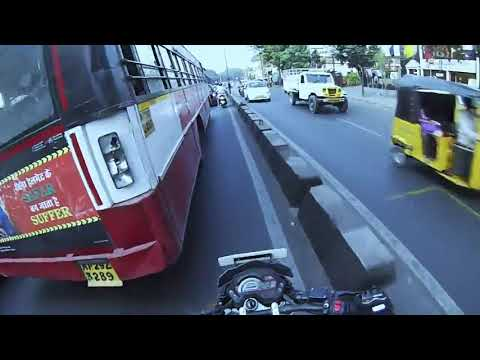

In [39]:
YouTubeVideo('NVMWAMqgT-Y',width="1000",height="500")



## Lets download the video and extract frames from it to process

In [40]:
video_address = 'https://www.youtube.com/watch?v=NVMWAMqgT-Y'
video = YouTube(video_address)
print(video.streams.all())
stream = video.streams[3]
stream.download()

<ipython-input-40-8920cb2c23ee>:3: DeprecationWarning: Call to deprecated function all (This object can be treated as a list, all() is useless).
  print(video.streams.all())


[<Stream: itag="17" mime_type="video/3gpp" res="144p" fps="7fps" vcodec="mp4v.20.3" acodec="mp4a.40.2" progressive="True" type="video">, <Stream: itag="18" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.42001E" acodec="mp4a.40.2" progressive="True" type="video">, <Stream: itag="22" mime_type="video/mp4" res="720p" fps="30fps" vcodec="avc1.64001F" acodec="mp4a.40.2" progressive="True" type="video">, <Stream: itag="136" mime_type="video/mp4" res="720p" fps="30fps" vcodec="avc1.4d401f" progressive="False" type="video">, <Stream: itag="135" mime_type="video/mp4" res="480p" fps="30fps" vcodec="avc1.4d400c" progressive="False" type="video">, <Stream: itag="134" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.4d401e" progressive="False" type="video">, <Stream: itag="133" mime_type="video/mp4" res="240p" fps="30fps" vcodec="avc1.4d400c" progressive="False" type="video">, <Stream: itag="160" mime_type="video/mp4" res="144p" fps="30fps" vcodec="avc1.4d400b" progressive="Fals

'/content/2 min of Indian driving in traffic.mp4'

In [41]:
del video, stream

In [42]:
video_capture = cv2.VideoCapture('/content/2 min of Indian driving in traffic.mp4')
current_frame = 0
if not os.path.exists('/content/video_images'):
  os.makedirs('/content/video_images')

In [43]:
while (True):
  success,frame = video_capture.read()
  #3print(frame)
  #cv2_imshow(frame)
  #print(success)
  if success == True:
    cv2.imwrite('/content/video_images/frame' + str(current_frame) +  '.jpg',frame)
    current_frame+=1
    if cv2.waitKey(1) & 0xFF == ord('q'):
      break
  else:
    break

video_capture.release()
cv2.destroyAllWindows()

In [44]:
if not os.path.exists('/content/predicted_video_images'):
  os.makedirs('/content/predicted_video_images')

In [45]:
data_dir = '/content/video_images'
data_dir = pathlib.Path(data_dir)
image_files = list(data_dir.glob('*'))
image_files = sorted([str(i) for i in image_files])
image_files[0]

'/content/video_images/frame0.jpg'

In [46]:
for image in tqdm(image_files):
  processed_image = cv2.imread(image, cv2.IMREAD_UNCHANGED)
  processed_image = cv2.resize(processed_image, (512, 512),  interpolation = cv2.INTER_AREA)
  processed_image = cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB)
  processed_image = processed_image/255
  processed_image = np.expand_dims(processed_image, axis=0)
  #plt.imshow(processed_image[0,:,:])
  #plt.show()
  pred = unet_model.predict(processed_image,verbose=0)
  pred = tf.argmax(pred, axis=-1)
  #plt.imshow(pred[0,:,:])
  #plt.show()
  #print(np.array(pred[0,:,:]))
  max_val = np.max(np.array(pred[0,:,:]))
  change_path = image.replace('video_images','predicted_video_images')
  cv2.imwrite(change_path,(np.array(pred[0,:,:]/max_val)*255))



100%|██████████| 3596/3596 [08:53<00:00,  6.74it/s]


## Lets Re create video

In [50]:
img_array = []
file_names = sorted(glob.glob('/content/predicted_video_images/*.jpg'))
for filename in file_names:
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

out = cv2.VideoWriter('predicted_indian_driving_traffic.mp4',cv2.VideoWriter_fourcc(*'mp4v'), 17, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

## Lets see the predicted video

In [49]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('/content/predicted_indian_driving_traffic.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)